In [1]:
from dataloader import DAVIS_Seq2, normalize_image, BallDataset, Balltest
from model import GeneralExtra, ResBlock, CoordConv
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL.Image as Image
import numpy as np
from preprocess_utensils import get_gray_image, get_boundary_iou
import json
from loss import order_loss, chamer_distance_loss
import random
from ModelInfer import ModelInfer

In [2]:
data_set = BallDataset("ellipse/uniform_samples_80.json", output_first=True)
test_set = Balltest("ellipse/uniform_samples_80.json")
batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [3]:
first_frame, first_boundary, pre_frame, curr_frame, pre_boundary, curr_boundary, pre_idx, curr_idx = next(iter(data_loader))
pre_idx, curr_idx

(tensor([0]), tensor([1]))

Text(0.5, 1.0, 'First Frame in test set')

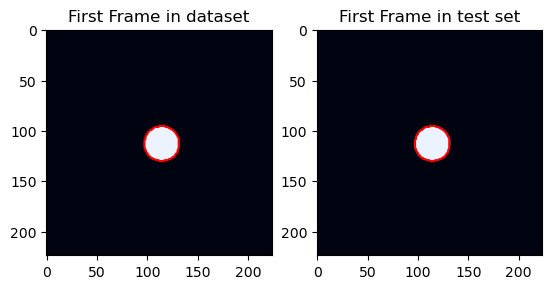

In [4]:
index = 0
plt.subplot(1, 2, 1)
plt.imshow(normalize_image(first_frame[index].permute(1, 2, 0)))
plt.plot(first_boundary[index][:, 0], first_boundary[index][:, 1], 'r')
plt.title("First Frame in dataset")
plt.subplot(1, 2, 2)
plt.imshow(normalize_image(test_set[0][0].permute(1, 2, 0)))
plt.plot(first_boundary[index][:, 0], first_boundary[index][:, 1], 'r')
plt.title("First Frame in test set")

Text(0.5, 1.0, 'Curr Frame')

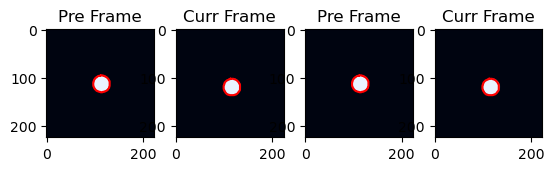

In [5]:
index = 0
plt.subplot(1, 4, 1)
plt.imshow(normalize_image(pre_frame[index].permute(1, 2, 0)))
plt.plot(pre_boundary[index][:, 0], pre_boundary[index][:, 1], 'r')
plt.title('Pre Frame')
plt.subplot(1, 4, 2)
plt.imshow(normalize_image(curr_frame[index].permute(1, 2, 0)))
plt.plot(curr_boundary[index][:, 0], curr_boundary[index][:, 1], 'r')
plt.title('Curr Frame')
plt.subplot(1, 4, 3)
plt.imshow(normalize_image(test_set[pre_idx][0].permute(1, 2, 0)))
plt.plot(pre_boundary[index][:, 0], pre_boundary[index][:, 1], 'r')
plt.title('Pre Frame')
plt.subplot(1, 4, 4)
plt.imshow(normalize_image(test_set[curr_idx][0].permute(1, 2, 0)))
plt.plot(curr_boundary[index][:, 0], curr_boundary[index][:, 1], 'r')
plt.title('Curr Frame')

In [6]:
# extra_block = ResBlock(384, 384)
feat_dim = 1280
extra_block = nn.Sequential(
        nn.Conv2d(
            in_channels=feat_dim,
            out_channels=feat_dim,
            kernel_size=3,
            padding=1,
            stride=1,
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=feat_dim,
            out_channels=feat_dim,
            kernel_size=3,
            padding=1,
            stride=1,
        ),
        nn.ReLU(),
        CoordConv(feat_dim, feat_dim),
        nn.ReLU(),
    )
model = GeneralExtra(extra_block, encoder="resfpn")

/work3/s232248/miniconda3/envs/vos/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /zhome/32/f/202284/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167M/167M [00:01<00:00, 109MB/s]
/work3/s232248/miniconda3/envs/vos/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor i

In [7]:
model = model.cuda()
results = model(
    first_frame.cuda(),
    first_boundary.cuda(),
    pre_frame.cuda(),
    curr_frame.cuda(),
    pre_boundary.cuda(),
)

In [8]:
order_loss(results[-1], curr_boundary.cuda())

tensor(6.6822, device='cuda:0', grad_fn=<DivBackward0>)

In [9]:
test_set = Balltest("ellipse/uniform_samples_80.json")

In [10]:
model_infer = ModelInfer(test_set)

In [11]:
model_infer.infer_model(model)

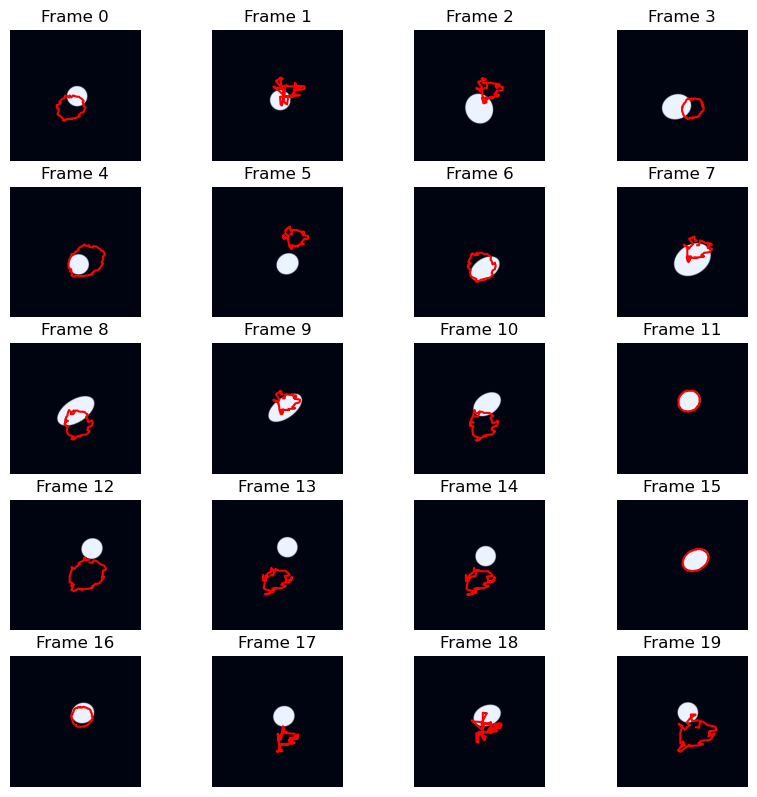

In [12]:
plt.figure(figsize=(10, 20))
for i in range(len(test_set)):
    plt.subplot(10, 4, i + 1)
    img, sgm, boundary = test_set[i]
    plt.imshow(normalize_image(img.permute(1, 2, 0)))
    boundary = model_infer.get_boundary(i)
    plt.plot(boundary.cpu()[:, 0], boundary.cpu()[:, 1], "r")
    plt.axis("off")
    plt.title(f"Frame {i}")

In [13]:
# extra_block = ResBlock(384, 384)
feat_dim = 1280
extra_block = nn.Sequential(
        nn.Conv2d(
            in_channels=feat_dim,
            out_channels=feat_dim,
            kernel_size=3,
            padding=1,
            stride=1,
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=feat_dim,
            out_channels=feat_dim,
            kernel_size=3,
            padding=1,
            stride=1,
        ),
        nn.ReLU(),
        CoordConv(feat_dim, feat_dim),
        nn.ReLU(),
    )
model = GeneralExtra(extra_block, encoder="resfpn").cuda()
model_infer = ModelInfer(test_set)
data_set = BallDataset("ellipse/uniform_samples_80.json", output_first=True)
loss_func = order_loss
batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

/work3/s232248/miniconda3/envs/vos/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/work3/s232248/miniconda3/envs/vos/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [14]:
dict_loss = {}
dict_iou = {}
interval_epochs = 50
interval_num = 155
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
gradient_clip = 2
test_set = Balltest("ellipse/uniform_samples_80.json")
model_infer = ModelInfer(test_set)
epoch_index = 0

In [21]:
interval_num = 155 + 200

In [15]:
for interval in range(interval_num):
    for e in range(interval_epochs):
        model.train()
        mean_loss = 0
        for first_frame, first_boundary, pre_frame, curr_frame, pre_boundary, curr_boundary, pre_idx, curr_idx in data_loader:
            pre_idx = pre_idx.item()
            curr_idx = curr_idx.item()
            pre_boundary = model_infer.get_boundary(pre_idx)
            pre_boundary = pre_boundary.unsqueeze(0).to("cuda")
            first_boundary = first_boundary.to("cuda")
            first_frame, first_boundary, pre_frame, curr_frame, pre_boundary, curr_boundary = (
                first_frame.to("cuda"),
                first_boundary.to("cuda"),
                pre_frame.to("cuda"),
                curr_frame.to("cuda"),
                pre_boundary.to("cuda"),
                curr_boundary.to("cuda"),
            )
            optimizer.zero_grad()
            results = model(first_frame, first_boundary, pre_frame, curr_frame, pre_boundary)
            refine_num = len(results)
            loss = 0
            for i in range(refine_num):
                loss += 0.8 ** (refine_num - i - 1) * loss_func(results[i], curr_boundary)
            mean_loss += loss.item()
            # nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
            loss.backward()
            optimizer.step()
        mean_loss /= len(data_loader)
        epoch_index += 1
        print(f"Epoch {epoch_index}, Loss: {mean_loss:.2f}")
        dict_loss[epoch_index] = mean_loss
    model_infer.infer_model(model)
    iou = model_infer.show_infer_result(0)
    dict_iou[epoch_index] = iou
    print(f"Epoch {epoch_index}, IOU: {iou:5f}")
    if interval_epochs > 100:
        interval_epochs = 50
    elif interval_epochs > 5:
        interval_epochs -= 5

Epoch 1, Loss: 47.19
Epoch 2, Loss: 42.25


KeyboardInterrupt: 

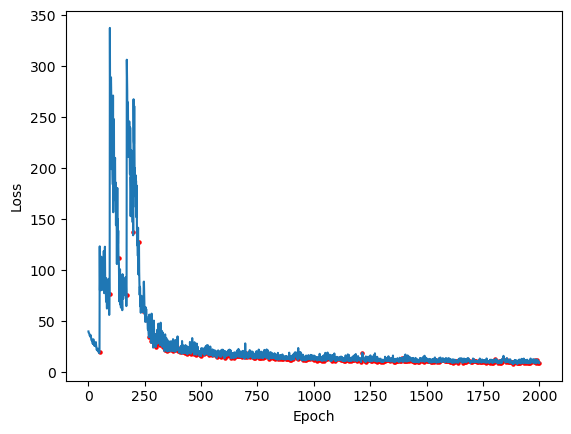

In [46]:
# plot the loss
plt.plot(list(dict_loss.keys()), list(dict_loss.values()))
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plot the update points
plt.scatter(list(dict_iou.keys()), [dict_loss[i] for i in list(dict_iou.keys())], c="r", s=5)
plt.show()

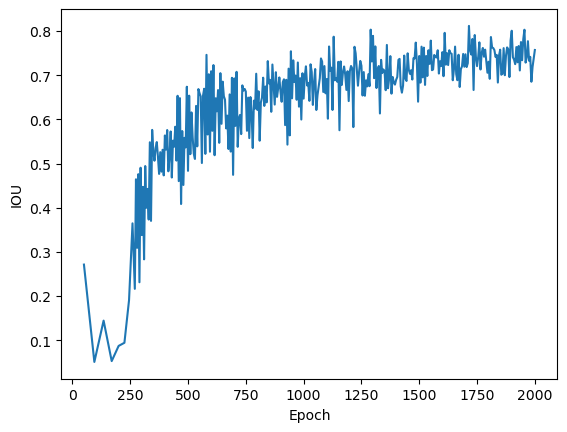

In [47]:
# plot the iou
plt.plot(list(dict_iou.keys()), list(dict_iou.values()))
plt.xlabel("Epoch")
plt.ylabel("IOU")
plt.show()

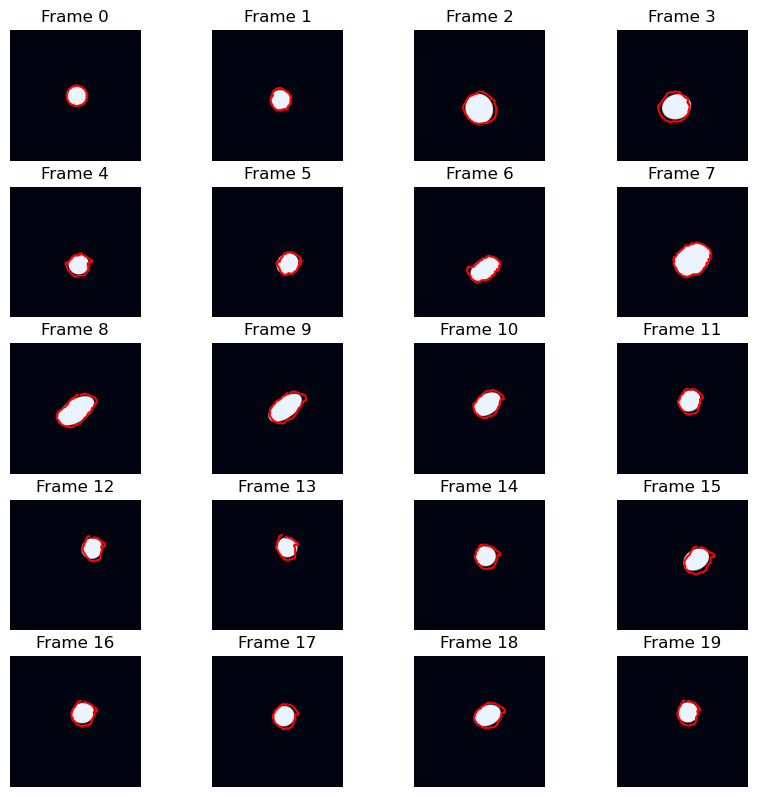

0.7571879731951824

In [50]:
model_infer.show_infer_result(0)

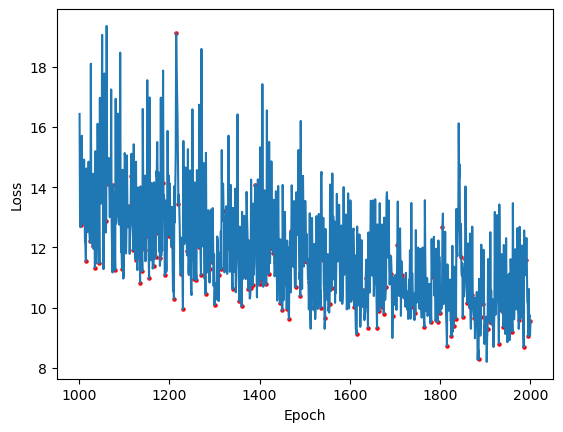

In [52]:
# plot last 1000 epochs loss
plt.plot(list(dict_loss.keys())[-1000:], list(dict_loss.values())[-1000:])
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plot the update points
plt.scatter(
    list(dict_iou.keys())[-200:], [dict_loss[i] for i in list(dict_iou.keys())[-200:]], c="r", s=5
)
plt.show()

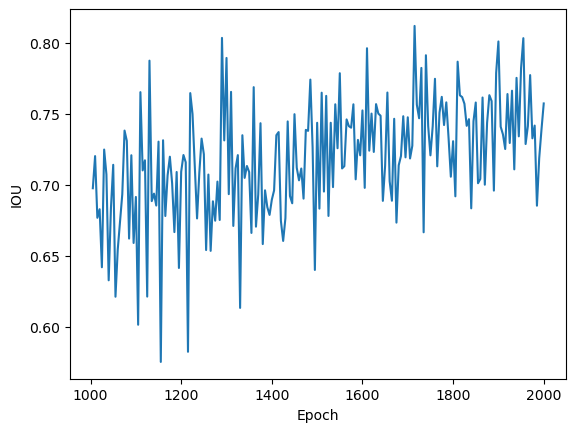

In [53]:
# plot last 1000 epochs iou
last_index = -200
plt.plot(list(dict_iou.keys())[last_index:], list(dict_iou.values())[last_index:])
plt.xlabel("Epoch")
plt.ylabel("IOU")
plt.show()
